In [1]:
!pip3 install imutils
!pip3 install torchsummary
from torchsummary import summary
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image
import imutils
import cv2
from matplotlib import pyplot as plt
import torchvision.models as models

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=df9ff6e09caa0019e237b72e6c0dd8b8e606c3aa238bfbb3d015c695f0986a2d
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [14]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
# If the images in the data set are readable,
# So we include it if it's not wrong.
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

In [4]:
# locations of data
train_data_path = "../input/cat-and-dog/training_set/training_set"
val_data_path = "../input/cat-and-dog/test_set/test_set"

In [5]:
image_test_cat = Image.open("../input/cat-and-dog/test_set/test_set/cats/cat.4001.jpg")
image_test_dog = Image.open("../input/cat-and-dog/test_set/test_set/dogs/dog.4003.jpg")

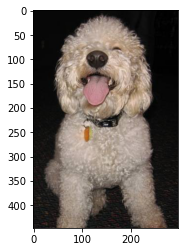

In [5]:
plt.imshow(image_test_dog)

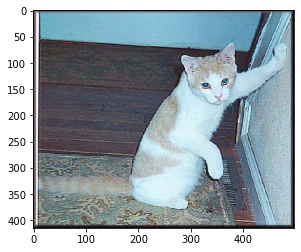

In [6]:
plt.imshow(image_test_cat)

In [6]:
# operations to convert images into vectors.
img_transforms = transforms.Compose([
    
    # we resize the pictures
    transforms.Resize((224,224)),
    transforms.ToTensor()
    ])


train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms, is_valid_file=check_image)


val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=img_transforms, is_valid_file=check_image)

In [7]:
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)

val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=True) 

In [9]:
class demirnet(nn.Module):
    
    def __init__(self):
        
        super(demirnet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(7 * 7 * 128, 250)
        self.fc2 = nn.Linear(250, 2)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.leaky_relu(self.conv2(x))
        x = self.maxpool2(x)
        x = F.leaky_relu(self.conv3(x))
        x = self.maxpool3(x)
        x = F.leaky_relu(self.conv4(x))
        x = self.maxpool4(x)
        x = F.leaky_relu(self.conv5(x))
        x = self.maxpool5(x)
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)


In [15]:
model = demirnet()
model=model.to(device) 

In [16]:
print(model)

demirnet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=250, bias=True)
  (fc2): Linear(in_features=250, out_features=2, bias=True)
)


In [17]:
loss_func = nn.CrossEntropyLoss()

opt = optim.Adam(model.parameters(), lr=1e-4)

In [18]:
def metrics_batch(target, output):
    pred = output.argmax(dim=1, keepdim=True)
    
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

In [19]:
def loss_batch(loss_func, xb, yb,yb_h, opt=None):
    
    loss = loss_func(yb_h, yb)
    
    metric_b = metrics_batch(yb,yb_h)
    
    if opt is not None:
        loss.backward() 
        opt.step() 
        opt.zero_grad() 

    return loss.item(), metric_b

In [20]:
def loss_epoch(model,loss_func,dataset_dl,opt=None):
    
    loss=0.0
    metric=0.0
    len_data=len(dataset_dl.dataset)
    for xb, yb in dataset_dl:
        xb=xb.type(torch.float).to(device)
        yb=yb.to(device)
        
        yb_h=model(xb)

        loss_b,metric_b=loss_batch(loss_func, xb, yb,yb_h, opt)
        loss+=loss_b
        if metric_b is not None:
            metric+=metric_b
            
    loss/=len_data 
    metric/=len_data
    return loss, metric

In [21]:
def train_val(epochs, model, loss_func, opt, train_dl, val_dl):
    
    for epoch in range(epochs):

        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,opt)
            
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl)

        print("epoch: %d, train loss: %.6f, val loss: %.6f, train accuracy: %.6f, val accuracy: %.6f" %(epoch, train_loss, val_loss, train_metric, val_metric))

In [22]:
# Training was done with 20 epoch twice. So he trained with 40 epochs in total.
# 20 + 20
num_epochs=3
train_val(num_epochs, model, loss_func, opt, train_data_loader, val_data_loader)

epoch: 0, train loss: 0.005398, val loss: 0.005182, train accuracy: 0.554653, val accuracy: 0.637173
epoch: 1, train loss: 0.005086, val loss: 0.005096, train accuracy: 0.628732, val accuracy: 0.626792
epoch: 2, train loss: 0.004739, val loss: 0.004652, train accuracy: 0.677951, val accuracy: 0.696490


In [23]:
!pip3 install wget
import wget
wget.download("https://www.dropbox.com/s/cclqhu19skquf0b/_92712149_gettyimages-480164327.jpg?dl=1")
wget.download("https://www.dropbox.com/s/5wu1stob9ys3eyt/images.jpeg?dl=1")

def image_loader(loader, image_name):
    image = Image.open(image_name)
    image = loader(image)
    image = torch.tensor(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image.to(device)

data_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9681 sha256=e99c64542b94a48371f67c76d5d7f1d9c5f48b2725b44cb9f729749bb610d0c1
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


torch.Size([1, 3, 224, 224])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


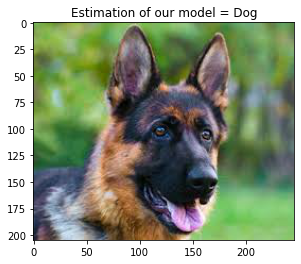

In [31]:
x = image_loader(data_transforms, "./images.jpeg")
print(x.shape)
z = model(x)
if z[0][0].item() > z[0][1].item():
    za = "Cat"
else:
    za = "Dog"

a = Image.open("./images.jpeg")
plt.title("Estimation of our model = {}".format(za))
plt.imshow(a)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


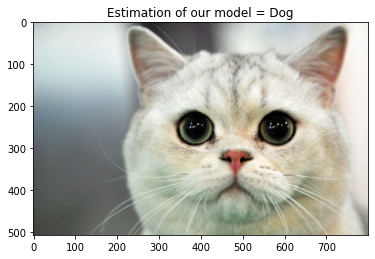

In [26]:
x = image_loader(data_transforms, "./_92712149_gettyimages-480164327.jpg")
z = model(x)
if z[0][0].item() > z[0][1].item():
    za = "Cat"
else:
    za = "Dog"

a = Image.open("./_92712149_gettyimages-480164327.jpg")
plt.title("Estimation of our model = {}".format(za))
plt.imshow(a)

## Integrated gradients

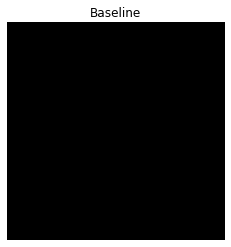

In [27]:
baseline = torch.zeros(size=(224,224,3))

plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

In [28]:
m_steps = 50
alphas = torch.linspace(start=0.0, end=1.0, steps=m_steps+1)

def interpolate_images(baseline, image, alphas):
    alphas_x = alphas.view(-1, 1, 1, 1)
    baseline_x = baseline.unsqueeze(0)
    input_x = image.permute(0,2,3,1)
    delta = input_x - baseline_x
    images = baseline_x + alphas_x * delta
    return images

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

baseline = baseline.to(device)
x = x.to(device)
alphas = alphas.to(device)

interpolated_images = interpolate_images(baseline=baseline, image=x, alphas=alphas)

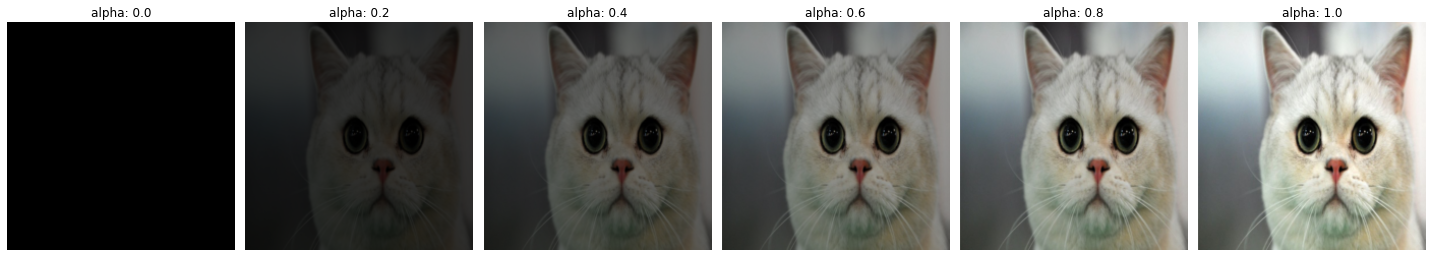

In [29]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
    i += 1
    plt.subplot(1, len(alphas[0::10]), i)
    plt.title(f'alpha: {alpha:.1f}')
    plt.imshow(image.cpu().detach().numpy())
    plt.axis('off')

plt.tight_layout();

In [36]:
def compute_gradients(images, target_class_idx):
    images = images.requires_grad_()
    images = images.permute(0,3,1,2)
    print(images.shape)
    logits = model(images)
    
    probs = F.softmax(logits, dim=-1)[:, target_class_idx]
    
    probs.sum().backward(retain_graph=True) # FIXME: check if sum is better than mean ????
    gradients = images.grad
    
    return gradients

path_gradients = compute_gradients(images=interpolated_images, target_class_idx=1)
print(path_gradients.shape)

torch.Size([51, 3, 224, 224])


RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

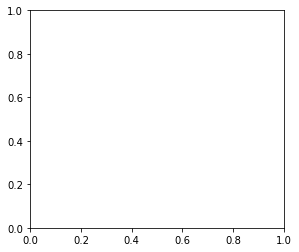

In [72]:
pred = model(interpolated_images.permute(0,3,1,2))
pred_proba = torch.nn.functional.softmax(pred, dim=-1)[:, 555].cpu().detach().numpy()

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = torch.mean(path_gradients, dim=(1, 2, 3))
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads - torch.min(average_grads)) / (torch.max(average_grads) - torch.min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1]);

In [ ]:
def integral_approximation(gradients):
    grads = (gradients[:-1] + gradients[1:]) / 2.0
    integrated_gradients = torch.mean(grads, dim=0)
    return integrated_gradients

ig = integral_approximation(gradients=path_gradients)
print(ig.shape)

In [ ]:
def integrated_gradients(baseline, image, target_class_idx, m_steps=50, batch_size=32):
    alphas = torch.linspace(start=0.0, end=1.0, steps=m_steps+1)

    gradient_batches = []

    for alpha in torch.arange(0, len(alphas), batch_size):
        from_ = alpha
        to = min(from_ + batch_size, len(alphas))
        alpha_batch = alphas[int(from_): int(to)]

        gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx)
        gradient_batches.append(gradient_batch)

    total_gradients = torch.cat(gradient_batches, dim=0)
    
    avg_gradients = integral_approximation(gradients=total_gradients)

    integrated_gradients = (image.squeeze(0).permute(1,2,0) - baseline)
    integrated_gradients *= avg_gradients

    return integrated_gradients

def one_batch(baseline, image, alpha_batch, target_class_idx):
    interpolated_path_input_batch = interpolate_images(baseline=baseline, image=image, alphas=alpha_batch)
    gradient_batch = compute_gradients(images=interpolated_path_input_batch, target_class_idx=target_class_idx)
    return gradient_batch

ig_attributions = integrated_gradients(baseline=baseline, image=x, target_class_idx=328, m_steps=240)
print(ig_attributions.shape)

In [ ]:
def plot_img_attributions(baseline,image,target_class_idx,m_steps=50,cmap=None,overlay_alpha=0.4):
    attributions = integrated_gradients(baseline=baseline,image=image,target_class_idx=target_class_idx,m_steps=m_steps)
    attribution_mask = torch.sum(torch.abs(attributions), dim=-1)

    fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

    axs[0, 0].set_title('Baseline image')
    axs[0, 0].imshow(baseline)
    axs[0, 0].axis('off')

    axs[0, 1].set_title('Original image')
    axs[0, 1].imshow(image.squeeze(0).permute(1,2,0))
    axs[0, 1].axis('off')

    print(attribution_mask.shape)
    axs[1, 0].set_title('Attribution mask')
    axs[1, 0].imshow(attribution_mask, cmap=cmap)
    axs[1, 0].axis('off')

    axs[1, 1].set_title('Overlay')
    axs[1, 1].imshow(attribution_mask, cmap=cmap)
    axs[1, 1].imshow(image.squeeze(0).permute(1,2,0), alpha=overlay_alpha)
    axs[1, 1].axis('off')

    plt.tight_layout()
    return fig

_ = plot_img_attributions(image=img_name_tensors['Starfish'], baseline=baseline, target_class_idx=328, m_steps=240, cmap=plt.cm.inferno, overlay_alpha=0.4)